<div class="alert alert-block alert-info">
<b>Deadline:</b> May 03, 2023 (Wednesday) 23:00
</div>

# Exercise 2. Denoising autoencoders

The goal of this exercise is to get familiar with *denoising* autoencoders.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

In this exercise, we will use MNIST to create a new dataset (that we call varianceMNIST). In the new dataset, the information about the shapes of the digits is represented in the variances of the pixel intensities and not in the pixel intensities (like in MNIST). We use a custom `transform.Lambda()` to generate the dataset. Note that our dataset contains an infinite amount of samples because we generate different noise instances every time we request the data. The number of shapes is of course limited to the number of digits in the MNIST dataset.

This is a challenging dataset and a plain bottleneck autoencoder (from  notebook 1) with a mean-squared error (MSE) loss cannot encode useful information in the bottleneck layer. However, a denoising autoencoder trained with an MSE loss is able to encode the shapes of the digits in the bottleneck layer.

In [7]:
# We will use varianceMNIST data in this exercise
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Lambda(lambda x: x * torch.randn_like(x))
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

We visualize some random training samples in the cell below. As you can see, we can quite easily identify the shapes and recognize the digits.

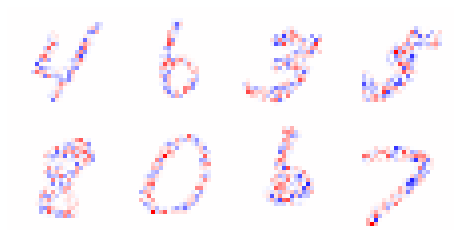

In [8]:
images, labels = next(iter(trainloader))
tools.show_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])

# Denoising autoencoder (DAE)

### Optimal denoising function

Suppose we corrupt an image $\mathbf{x}$ of the varianceMNIST dataset with a zero-mean Gaussian noise with standard deviation $\sigma_n$. For a given clean pixel value $x$, the corrupted value $\tilde{x}$ is thus produced as:
$$
\tilde{x} = x + n, \qquad n \sim \mathcal{N}(0, \sigma^2_n)
$$
Please do not confuse the corruption process with the generative process of the varianceMNIST dataset. We assume that the varianceMNIST dataset is given to us, while we are free to select any corruption process to train a DAE. In this experiment, we choose Gaussian corruption.

Knowing the generative process of the varianceMNIST dataset (which is a bit of cheating because we usually do not know the data generative process), we can compute the optimal denoising function which produces an estimate of the clean pixel value $x$ given corrupted value $\tilde{x}$:
$$
g(\tilde{x}) = \tilde{x} \: \text{sigmoid}(f(\sigma_x^2, \sigma_n^2))
$$
where $f$ is some function of the variance $\sigma^2_x$ of a pixel intensity in the varianceMNIST dataset and the variance $\sigma^2_n$ of the corruption noise.


In the cell below, your task is to implement a denoising autoencoder (DAE) which can learn to approximate the optimal denoising function shown above.
* Our DAE will be trained to learn the optimal denoising function $g(\tilde{x})$. In each training iteration, we feed corrupted images $\tilde{\mathbf{x}}$ to the inputs of the DAE and provide the corresponding clean images $\mathbf{x}$ as the targets for the DAE outputs.
* To learn useful representations (the shapes of the digits for the varianceMNIST dataset), our DAE will have a bottleneck layer with `n_components` elements. It is the output of the encoder.
* We are not going to use values of $\sigma_x^2$ and $\sigma_n^2$ inside the DAE: The value of $\sigma_x^2$ we simply do not know. We know the value of $\sigma_n^2$ (because we select the corruption process) but we are not going to use that value in the computations of the denoising function.
* Look carefully at the structure of the optimal denoising function. We can select the architecture of the DAE that makes it easy to perform the computations needed for optimal denoising.

The proposed architecture for the DAE:
* Encoder:
    * `Conv2d` layer with kernel size 5 with 6 output channels, followed by ReLU
    * `Conv2d` layer with kernel size 5 with 16 output channels, followed by ReLU
    * Fully-connected layer with 250 output features, followed by ReLU
    * Fully-connected layer with `n_components`
* Decoder:
    * Fully-connected layer with 250 output features, followed by ReLU
    * Fully-connected layer with 250 input features, followed by ReLU
    * `ConvTranspose2d` layer with kernel size 5 with 16 input channels, followed by ReLU
    * `ConvTranspose2d` layer with kernel size 5 with 6 input channels

Notes:
* The exact architecture is not tested in this notebook. The above description is not full, you need to add some missing connections using the knowledge of the form of the optimal denoising function.
* Please use recommended convolutional layers in the encoder and the decoder. If the autoencoder consists of only fully-connected layers, the learning problem is harder.

In [26]:
class DAE(nn.Module):
    def __init__(self, n_components=10):
        """
        Args:
          n_components (int): Number of outputs in the bottleneck layer.
        """
        # YOUR CODE HERE
        super(DAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=16*20*20, out_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=n_components),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=n_components, out_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=16*20*20),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(16, 20, 20)),
            nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width, height): Examples corrupted with noise.

        Returns:
          z of shape (batch_size, n_components): Outputs of the bottleneck layer.
          denoised_x of shape (batch_size, n_channels=1, width, height): Denoised examples.
        """
        z = self.encoder(x)
        denoised_x = self.decoder(z)
        return z, x*denoised_x

In [27]:
def test_DAE_shapes():
    n_components = 2
    dae = DAE(n_components)

    x = torch.randn(3, 1, 28, 28)
    z, y = dae(x)
    assert z.shape == torch.Size([3, n_components]), f"Bad z.shape: {z.shape}"
    assert y.shape == x.shape, "Bad y.shape: {y.shape}"
    print('Success')

test_DAE_shapes()

Success


# Train a denoising autoencoder

In [28]:
# Create an autoencoder
n_components = 10
dae = DAE(n_components)
dae.to(device)

DAE(
  (encoder): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=6400, out_features=250, bias=True)
    (6): ReLU()
    (7): Linear(in_features=250, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=6400, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(16, 20, 20))
    (5): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(6, 1, kernel_size=(5, 5), stride=(1, 1))
    (8): Sigmoid()
  )
)

### Training loop

Implement the training loop in the cell below. Training proceeds similarly to the standard bottleneck autoencoder. The difference is that the encoder gets *corrupted* training images as inputs and the targets are the varianceMNIST digits without the corruption noise.

The recommended hyperparameters:
* Corruption of varianceMNIST images with **additive** Gaussian noise with zero mean and standard deivation $\sigma_n=0.2$.
* Adam optimizer with learning rate 0.001
* MSE loss

Hints:
- Training usually converges fast, a couple of epochs should suffice.
- The loss at convergence should be close to 0.009.

In [29]:
# Training loop
if not skip_training:
# YOUR CODE HERE

    optimizer = optim.Adam(dae.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Train the autoencoder
    num_epochs = 10
    total_loss = 0
    for epoch in range(num_epochs):
        for data in trainloader:
            
            # Add noise to the input images
            inputs, _ = data
            inputs_noisy = inputs + 0.2 * torch.randn_like(inputs)
            
            inputs = inputs.to(device)
            inputs_noisy = inputs_noisy.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            z, outputs = dae(inputs_noisy)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        total_loss /= len(trainloader)
        print(f"Epoch {epoch+1}, loss: {total_loss}")

    print('Finished Training')
    

Epoch 1, loss: 0.011027373331785202
Epoch 2, loss: 0.008979137768325806
Epoch 3, loss: 0.008679329587154243
Epoch 4, loss: 0.008502131781320775
Epoch 5, loss: 0.008372245826317253
Epoch 6, loss: 0.008296267240993443
Epoch 7, loss: 0.008252405239949492
Epoch 8, loss: 0.008195355253991848
Epoch 9, loss: 0.00816830286592183
Epoch 10, loss: 0.008119108622977256
Finished Training


In [30]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(dae, '2_dae.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 2_dae.pth.


In [31]:
if skip_training:
    dae = DAE(n_components=10)
    tools.load_model(dae, '2_dae.pth', device)

### Visualize embeddings

Let us visualize the latent space in the cell below. If your DAE does a good job, you should clearly see ten clusters corresponding to the ten classes.

Use t-SNE
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


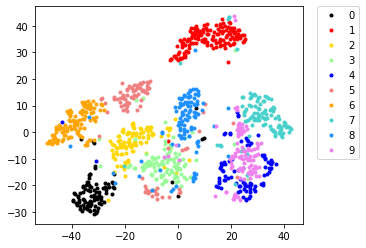

In [32]:
tests.visualize_embeddings(lambda x: dae(x)[0], trainloader, n_samples=1000, device=device)

In the cell below, we denoise some test images using the trained DAE. If your DAE does a good job, it should remove noise from the background.

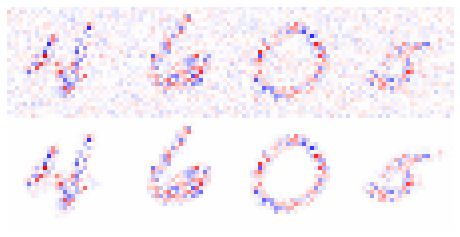

In [33]:
@torch.no_grad()
def plot_denoising(trainloader):
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    images = images[:4].to(device)

    corrupted_images = images + 0.2 * torch.randn_like(images)
    z, reconstructions = dae(corrupted_images)
    tools.show_images(
        torch.cat([corrupted_images, reconstructions]),
        ncol=4, cmap=plt.cm.bwr, clim=[-3,3]
    )

plot_denoising(trainloader)

## Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a simple linear regression classifier using the encoded images. If the classifier gives a reasonable accuracy, this is an evidence that we learned to represent the shapes of the digits in the bottleneck layer.

In [34]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [35]:
# Encode data samples using the encoder
@torch.no_grad()
def encode(dataset, dae):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    embeddings = []
    labels = []
    for images, labels_ in dataloader:
        z, rec = dae(images.to(device))
        embeddings.append(z)
        labels.append(labels_)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

In [36]:
# Save and submit the DAE embeddings
if not skip_training:
    traincodes, trainlabels = encode(trainset, dae)  # traincodes is (60000, 10)
    testcodes, testlabels = encode(testset, dae)  # testcodes is (10000, 10)
    torch.save([traincodes, trainlabels, testcodes, testlabels], '2_dae_embeddings.pth')
else:
    traincodes, trainlabels, testcodes, testlabels = torch.load('2_dae_embeddings.pth', map_location=lambda storage, loc: storage)

In [37]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter=200)
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .83, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 89.76%
Success


<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

In this exercise, we trained a denoising autoencoder to encode meaningful information in the bottleneck layer. The codes produced in the bottleneck layer are only 10-dimensional but they can represent useful information present in the original $28 \times 28 = 784$-dimensional images. You can try to use in this task a plain bottleneck autoencoder (trained without the corruption process) with MSE loss and you will see that it fails to develop useful representations.